In [1]:
import numpy as np # linear algebra
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import hopsworks

2023-01-13 16:29:42.533444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 16:29:43.043508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 16:29:43.043538: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-13 16:29:44.482439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
project = hopsworks.login()
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4247


Connected. Call `.close()` to terminate connection gracefully.


In [18]:
try: 
    feature_view = fs.get_feature_view(name="new_electricity_data_fv", version=1)
except:
    electricity_data_fg = fs.get_feature_group('new_electricity_data_fg', version=1)
    query = electricity_data_fg.select_all()    
    feature_view = fs.create_feature_view(name="new_electricity_data_fv",
                                        version=1, # labels: "day_ahead_price"
                                        description="Read from Feature Group new_electricity_data_fg",
                                        query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/4247/fs/4192/fv/new_electricity_data_fv/version/1


In [ ]:
# electricity_data_fg.read()
# query_show = electricity_data_fg.show(5)
# col_names = query_show.columns

In [19]:
version, job = feature_view.create_training_data(
    description = 'new electricity price pred train data',
    data_format = 'csv',
    write_options = {"wait_for_job": False}
) # By default, it is materialised to HopsFS
print(job.id) 

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/4247/jobs/named/new_electricity_data_fv_1_1_create_fv_td_13012023154113/executions
17460


In [20]:
train_data = feature_view.get_training_data(training_dataset_version=1)[0]
train_data = train_data.sort_values(by=['datetime'])
train_data

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,datetime,day_ahead_price,total_load,temperature
1282,824.0,5841.0,892.0,0.0,1062.0,1640991600000,46.60,9685.0,5.3
1384,818.0,5842.0,851.0,0.0,999.0,1640995200000,41.33,9612.0,5.4
7209,818.0,5839.0,858.0,0.0,958.0,1640998800000,42.18,9601.0,5.4
4637,838.0,5839.0,859.0,0.0,888.0,1641002400000,44.37,9552.0,5.7
6484,842.0,5840.0,856.0,0.0,788.0,1641006000000,37.67,9449.0,5.3
...,...,...,...,...,...,...,...,...,...
8783,1098.0,5798.0,954.0,0.0,504.0,1672682400000,164.46,11650.0,4.2
8793,1072.0,5797.0,941.0,0.0,605.0,1672686000000,153.00,11346.0,4.1
8785,828.0,5799.0,940.0,0.0,682.0,1672689600000,141.67,10959.0,5.0
8784,747.0,5800.0,913.0,0.0,740.0,1672693200000,131.67,10536.0,4.9


In [21]:
train_data.set_index('datetime', inplace=True)
train_data

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1640991600000,824.0,5841.0,892.0,0.0,1062.0,46.60,9685.0,5.3
1640995200000,818.0,5842.0,851.0,0.0,999.0,41.33,9612.0,5.4
1640998800000,818.0,5839.0,858.0,0.0,958.0,42.18,9601.0,5.4
1641002400000,838.0,5839.0,859.0,0.0,888.0,44.37,9552.0,5.7
1641006000000,842.0,5840.0,856.0,0.0,788.0,37.67,9449.0,5.3
...,...,...,...,...,...,...,...,...
1672682400000,1098.0,5798.0,954.0,0.0,504.0,164.46,11650.0,4.2
1672686000000,1072.0,5797.0,941.0,0.0,605.0,153.00,11346.0,4.1
1672689600000,828.0,5799.0,940.0,0.0,682.0,141.67,10959.0,5.0


In [22]:
# Split into train & test sets
train_size = int(len(train_data) * 0.80)
test_size = len(train_data) - train_size
test = train_data.iloc[train_size:,:]
train = train_data.iloc[0:train_size,:]

In [23]:
train.head()

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1640991600000,824.0,5841.0,892.0,0.0,1062.0,46.60,9685.0,5.3
1640995200000,818.0,5842.0,851.0,0.0,999.0,41.33,9612.0,5.4
1640998800000,818.0,5839.0,858.0,0.0,958.0,42.18,9601.0,5.4
1641002400000,838.0,5839.0,859.0,0.0,888.0,44.37,9552.0,5.7
1641006000000,842.0,5840.0,856.0,0.0,788.0,37.67,9449.0,5.3


In [24]:
test.head()

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1666350000000,798.0,5670.0,804.0,57.0,461.0,159.64,9957.0,10.2
1666353600000,732.0,5670.0,819.0,43.0,440.0,156.83,9827.0,9.9
1666357200000,741.0,5669.0,821.0,24.0,419.0,153.78,9806.0,9.4
1666360800000,772.0,5665.0,820.0,8.0,413.0,158.25,9823.0,9.2
1666364400000,787.0,5664.0,813.0,1.0,435.0,167.20,10212.0,9.1


In [25]:
# Standard scaler for features and label

sc_x=StandardScaler()
X_scaled_train=sc_x.fit_transform(train)

In [26]:
sc_y=StandardScaler()
y_scaled_train=sc_y.fit_transform(train[['day_ahead_price']])

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7041 entries, 1640991600000 to 1666346400000
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hydro_water_reservoir  7041 non-null   float64
 1   nuclear                7041 non-null   float64
 2   other                  7041 non-null   float64
 3   solar                  7041 non-null   float64
 4   wind_onshore           7041 non-null   float64
 5   day_ahead_price        7041 non-null   float64
 6   total_load             7041 non-null   float64
 7   temperature            7041 non-null   float64
dtypes: float64(8)
memory usage: 495.1 KB


In [28]:
step_back=24
no_records=len(train)
no_cols=8
X_train=[]
y_train=[]
for i in range(step_back,no_records):
    X_train.append(X_scaled_train[i-step_back:i])
    y_train.append(y_scaled_train[i][0])
X_train,y_train=np.array(X_train),np.array(y_train)

In [29]:
print(X_train.shape)
print(y_train.shape)

(7017, 24, 8)
(7017,)


In [30]:
X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape

(7017, 24, 8)

### LSTM model

In [31]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(step_back,no_cols)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

2023-01-13 16:44:17.854913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 16:44:17.855409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 16:44:17.856003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-13 16:44:17.856099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-13 16:44:17.856183: W tensorflow/c

In [32]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_lstm.fit(X_train_shape, y_train, epochs=200, batch_size=265, verbose=1, shuffle=False)

Epoch 1/200
27/27 [==============================] - 4s 49ms/step - loss: 0.8187
Epoch 2/200
27/27 [==============================] - 1s 47ms/step - loss: 0.4697
Epoch 3/200
27/27 [==============================] - 2s 75ms/step - loss: 0.3567
Epoch 4/200
27/27 [==============================] - 1s 55ms/step - loss: 0.2888
Epoch 5/200
27/27 [==============================] - 1s 48ms/step - loss: 0.2406
Epoch 6/200
27/27 [==============================] - 1s 49ms/step - loss: 0.2105
Epoch 7/200
27/27 [==============================] - 1s 50ms/step - loss: 0.1849
Epoch 8/200
27/27 [==============================] - 1s 53ms/step - loss: 0.1626
Epoch 9/200
27/27 [==============================] - 1s 48ms/step - loss: 0.1490
Epoch 10/200
27/27 [==============================] - 1s 50ms/step - loss: 0.1400
Epoch 11/200
27/27 [==============================] - 1s 55ms/step - loss: 0.1365
Epoch 12/200
27/27 [==============================] - 1s 52ms/step - loss: 0.1292
Epoch 13/200
27/27 [=====

In [34]:
last_24=train.iloc[-step_back:]
full_df= pd.concat((last_24,test),axis=0)
print(full_df.shape)
full_df.head()

(1785, 8)


,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1666263600000,783.0,5673.0,836.0,145.0,178.0,129.88,9713.0,11.4
1666267200000,778.0,5674.0,839.0,116.0,184.0,130.08,9761.0,11.0
1666270800000,775.0,5674.0,785.0,68.0,173.0,134.32,9764.0,9.9
1666274400000,777.0,5675.0,757.0,22.0,173.0,144.51,9812.0,8.3
1666278000000,812.0,5675.0,763.0,2.0,225.0,164.09,10246.0,7.3


In [35]:
full_df=sc_x.transform(full_df)
full_df.shape

(1785, 8)

In [36]:
step_back=step_back
no_records=len(full_df)
no_cols=no_cols
X_train_shape_pred=[]
for i in range(step_back,no_records):
    X_train_shape_pred.append(full_df[i-step_back:i])
X_train_shape_pred=np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(1761, 24, 8)


In [37]:
y_test=model_lstm.predict(X_train_shape_pred)

56/56 [==============================] - 1s 6ms/step


In [38]:
y_final_pred=sc_y.inverse_transform(y_test)
y_final_pred

array([[162.08998],
       [154.54097],
       [143.18192],
       ...,
       [141.04477],
       [132.77777],
       [136.46417]], dtype=float32)

In [39]:
final_pred=pd.DataFrame(y_final_pred)
final_pred.columns=['final_pred']
final_pred.head()

,final_pred
0,162.089981
1,154.540970
2,143.181915
3,136.312637
4,144.198044


In [40]:
test.reset_index(inplace=True)

In [41]:
fully_final=pd.concat((final_pred,test),axis=1)
fully_final

,final_pred,datetime,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
0,162.089981,1666350000000,798.0,5670.0,804.0,57.0,461.0,159.64,9957.0,10.2
1,154.540970,1666353600000,732.0,5670.0,819.0,43.0,440.0,156.83,9827.0,9.9
2,143.181915,1666357200000,741.0,5669.0,821.0,24.0,419.0,153.78,9806.0,9.4
3,136.312637,1666360800000,772.0,5665.0,820.0,8.0,413.0,158.25,9823.0,9.2
4,144.198044,1666364400000,787.0,5664.0,813.0,1.0,435.0,167.20,10212.0,9.1
...,...,...,...,...,...,...,...,...,...,...
1756,159.119476,1672682400000,1098.0,5798.0,954.0,0.0,504.0,164.46,11650.0,4.2
1757,146.998688,1672686000000,1072.0,5797.0,941.0,0.0,605.0,153.00,11346.0,4.1
1758,141.044769,1672689600000,828.0,5799.0,940.0,0.0,682.0,141.67,10959.0,5.0
1759,132.777771,1672693200000,747.0,5800.0,913.0,0.0,740.0,131.67,10536.0,4.9


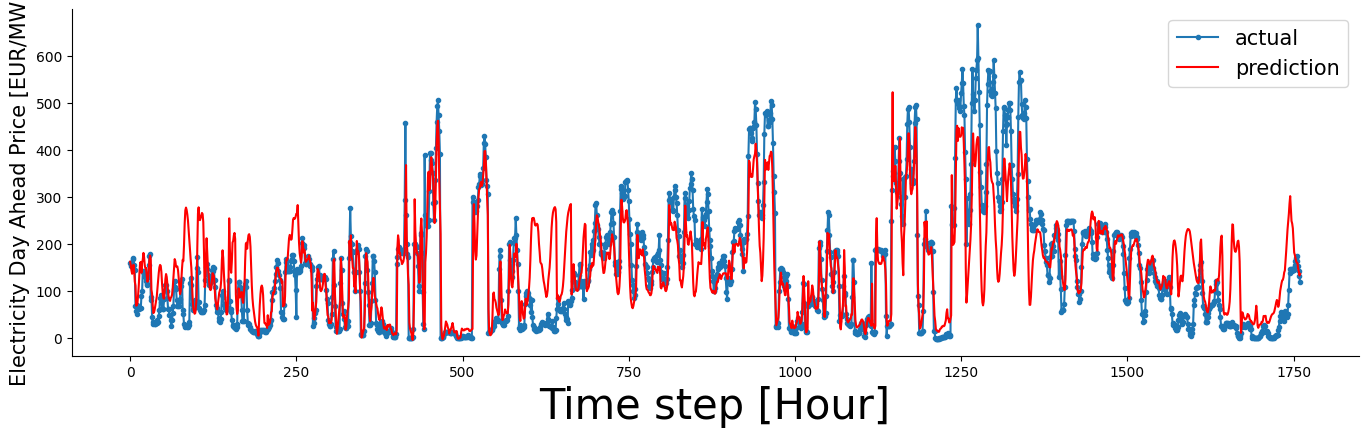

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
aa=[x for x in range(1761)]
plt.figure(figsize=(14,4))
plt.plot(aa, fully_final['day_ahead_price'], marker='.', label="actual")
plt.plot(aa, fully_final['final_pred'], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Electricity Day Ahead Price [EUR/MWh]', size=15)
plt.xlabel('Time step [Hour]', size=30)
plt.legend(fontsize=15)
plt.show();

### Upload model to hopsworks

In [43]:
import hopsworks

project = hopsworks.login() 
fs = project.get_feature_store() 
mr = project.get_model_registry()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4247
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [45]:
import os
import joblib
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

7017

In [54]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train_shape)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'tensor_schema': {'shape': '(7017, 24, 8)',
   'type': 'float64'}},
 'output_schema': {'tensor_schema': {'shape': '(7017,)', 'type': 'float64'}}}

In [ ]:
joblib.dump(model_lstm, model_dir + "/electricity_price.pkl")

In [60]:
from sklearn.metrics import mean_squared_error, r2_score 

In [66]:
print('R2 Score: ', r2_score(fully_final['day_ahead_price'], y_final_pred)) 
print('MAE: ', mean_absolute_error(fully_final['day_ahead_price'], y_final_pred)) 
print('mean_squared_error testing : ', mean_squared_error(fully_final['day_ahead_price'], y_final_pred))


R2 Score:  0.6533885945764686
MAE:  52.37991742359248
mean_squared_error testing :  5946.989784519626


In [65]:
model = mr.sklearn.create_model(
    name="SE3_elec_price_model",
    description="SE3 electricity price prediction",
    model_schema=model_schema,
)

model.save('model/electricity_price.pkl')

Model export complete: 100%|██████████| 6/6 [00:21<00:00,  3.51s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/4247/models/SE3_elec_price_model/1


Model(name: 'SE3_elec_price_model', version: 1)